In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import FeatureHasher

In [3]:
df = pd.read_csv("data/train_competition_2023.csv")

# Healthcare Data Competition Project

### Project Description

Context: Medical data from patients in the ER. 

There are multiple timepoints observed per patient. Some of the predictors are constant in time, some are dynamic. The responses y_1 and y_2 are the measurements of indicators of health (e.g. heart rate, arterial pressure) recorded after a 5 minute gap from the predictors. These responses are usually a sign of whether someone's condition is deterioriating to an extreme point. 


In [4]:
df.head(5)

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4,y_1,y_2
0,0,0,2068-09-19 23:34:11,1.38,49,7,1,3,1,0,1,105.5,95.0,67.4,36.6,23.2,33.4,107.4
1,0,0,2068-09-19 23:35:11,1.38,49,7,1,3,1,0,1,104.4,95.0,66.4,37.8,22.7,33.4,107.4
2,0,0,2068-09-19 23:36:11,1.38,49,7,1,3,1,0,1,104.0,95.0,65.2,37.0,22.1,33.4,107.4
3,0,0,2068-09-19 23:37:11,1.38,49,7,1,3,1,0,1,102.8,95.0,63.4,35.9,20.7,33.4,107.4
4,0,0,2068-09-19 23:38:11,1.38,49,7,1,3,1,0,1,101.3,95.1,59.1,34.5,18.1,33.4,107.4


### Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432600 entries, 0 to 432599
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   obs     432600 non-null  int64  
 1   sub_id  432600 non-null  int64  
 2   time    432600 non-null  object 
 3   num_0   432600 non-null  float64
 4   num_1   432600 non-null  int64  
 5   num_2   432600 non-null  int64  
 6   cat_0   432600 non-null  int64  
 7   cat_1   432600 non-null  int64  
 8   cat_2   432600 non-null  int64  
 9   cat_3   432600 non-null  int64  
 10  cat_4   432600 non-null  int64  
 11  t_0     432600 non-null  float64
 12  t_1     432600 non-null  float64
 13  t_2     432600 non-null  float64
 14  t_3     432600 non-null  float64
 15  t_4     432600 non-null  float64
 16  y_1     432600 non-null  float64
 17  y_2     432600 non-null  float64
dtypes: float64(8), int64(9), object(1)
memory usage: 59.4+ MB


I will break down the time column into different columns

In [6]:
df['time']=pd.to_datetime(df['time']) 
df['hour']=df['time'].dt.hour
df['month']=df['time'].dt.month
df['year']=df['time'].dt.year

Seems like each subject/patient has varying amount of data on them

In [7]:
df.groupby('sub_id').nunique()['obs']

sub_id
0       18
2        2
3        5
4        1
5       10
        ..
1988     2
1989     2
1990     2
1993    11
1995     4
Name: obs, Length: 1596, dtype: int64

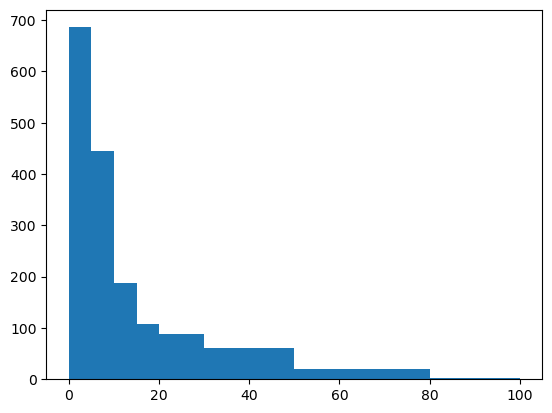

In [8]:
plt.hist(df.groupby('sub_id').nunique()['obs'],bins=[0,5,10,15,20,30,50,80,100])
plt.show()

In [9]:
#unique values in each column
for col in df.columns:
    print(f'{col}:{len(df[col].unique())}')

obs:14420
sub_id:1596
time:432352
num_0:71
num_1:76
num_2:20
cat_0:2
cat_1:5
cat_2:2
cat_3:2
cat_4:2
t_0:5972
t_1:1622
t_2:9424
t_3:5462
t_4:7433
y_1:4706
y_2:5601
hour:24
month:12
year:108


In [10]:
#unique values in each column for each sub
for col in df.columns:
    a='sub_id'
    if col!=a:
        uniq_by_sub=df.groupby(a).nunique()[col]
        max_val=uniq_by_sub.max()
        max_sub=uniq_by_sub[uniq_by_sub==max_val].index[0]
        print(f'Col name : {col} ; sub_id with max cnt : {max_sub}; max cnt:{max_val}')


Col name : obs ; sub_id with max cnt : 362; max cnt:117
Col name : time ; sub_id with max cnt : 362; max cnt:3510
Col name : num_0 ; sub_id with max cnt : 0; max cnt:1
Col name : num_1 ; sub_id with max cnt : 0; max cnt:1
Col name : num_2 ; sub_id with max cnt : 0; max cnt:1
Col name : cat_0 ; sub_id with max cnt : 0; max cnt:1
Col name : cat_1 ; sub_id with max cnt : 0; max cnt:1
Col name : cat_2 ; sub_id with max cnt : 0; max cnt:2
Col name : cat_3 ; sub_id with max cnt : 23; max cnt:2
Col name : cat_4 ; sub_id with max cnt : 0; max cnt:2
Col name : t_0 ; sub_id with max cnt : 375; max cnt:1149
Col name : t_1 ; sub_id with max cnt : 375; max cnt:599
Col name : t_2 ; sub_id with max cnt : 1422; max cnt:1572
Col name : t_3 ; sub_id with max cnt : 1422; max cnt:1204
Col name : t_4 ; sub_id with max cnt : 1422; max cnt:1365
Col name : y_1 ; sub_id with max cnt : 362; max cnt:115
Col name : y_2 ; sub_id with max cnt : 362; max cnt:115
Col name : hour ; sub_id with max cnt : 17; max cnt:24

In [11]:
#Data for sub_id==0
df[df['sub_id']==0].groupby('cat_2').mean()['y_2'],df[df['sub_id']==0].groupby('cat_2').mean()['y_1']

/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/2128207608.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['sub_id']==0].groupby('cat_2').mean()['y_2'],df[df['sub_id']==0].groupby('cat_2').mean()['y_1']
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/2128207608.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['sub_id']==0].groupby('cat_2').mean()['y_2'],df[df['sub_id']==0].groupby('cat_2').mean()['y_1']


(cat_2
 0    87.569231
 1    90.584000
 Name: y_2, dtype: float64,
 cat_2
 0    14.987692
 1    23.564000
 Name: y_1, dtype: float64)

Drop any duplicates

In [12]:
new_df=df[['sub_id','num_0','num_1','num_2','cat_0','cat_1','cat_2','cat_3','cat_4','t_0','t_1','t_2','t_3','t_4','y_1','y_2']].drop_duplicates()

In [13]:
df_test = pd.read_csv("data/test_no_outcome.csv")
df_test.head()
df_sample = pd.read_csv("data/sample_submission.csv")
df_sample.head()

,obs,y_1,y_2
0,18,42.0,82.0
1,19,42.0,82.0
2,20,42.0,82.0
3,21,42.0,82.0
4,22,42.0,82.0


In [14]:
not_present_el=list()
for el in df_test['sub_id'].unique():
    if el not in df['sub_id'].unique():
        not_present_el.append(el)

In [15]:
present_el=list()
for el in df_test['sub_id'].unique():
    if el in df['sub_id'].unique():
        present_el.append(el)

None of the subjects/patients in the training dataset is in the test set

In [16]:
len(present_el),len(not_present_el)

(0, 400)

Next I see how the target feature behaves grouping by the features 

/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/3119517994.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[i,0].plot(df.groupby(col).mean()['y_1'])
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/3119517994.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[i,1].plot(df.groupby(col).mean()['y_2'])
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/3119517994.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only

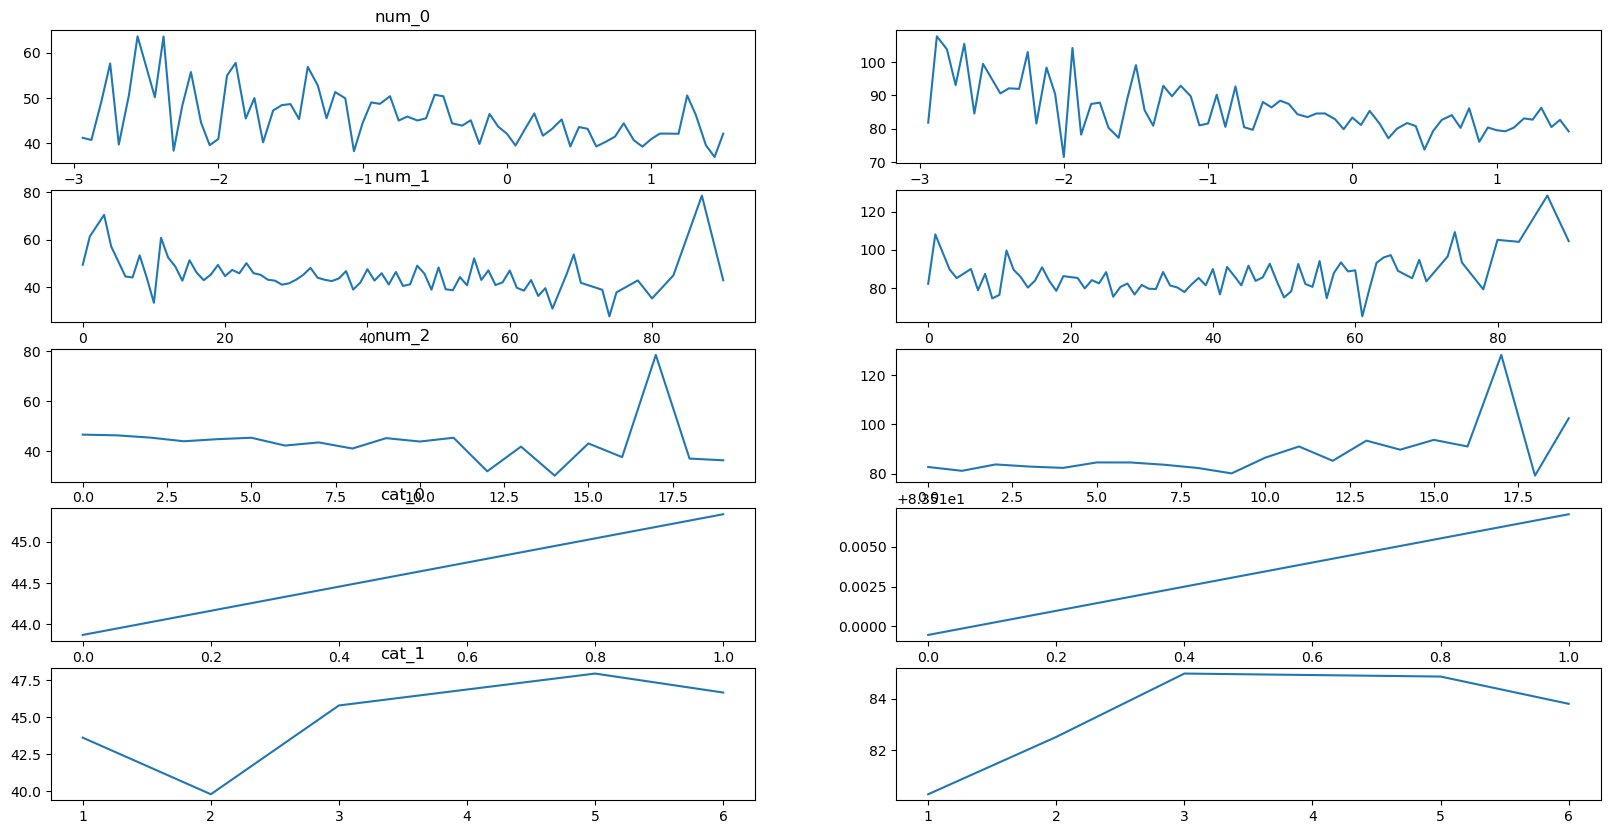

In [17]:
fig, ax=plt.subplots(nrows=5,ncols=2,figsize=(20,10))
for i,col in enumerate(df.columns[3:8]):
    ax[i,0].set_title(col)
    ax[i,0].plot(df.groupby(col).mean()['y_1'])
    ax[i,1].plot(df.groupby(col).mean()['y_2'])
plt.show()

/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/146307232.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[i,0].plot(df.groupby(col).mean()['y_1'])
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/146307232.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[i,1].plot(df.groupby(col).mean()['y_2'])
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/146307232.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only co

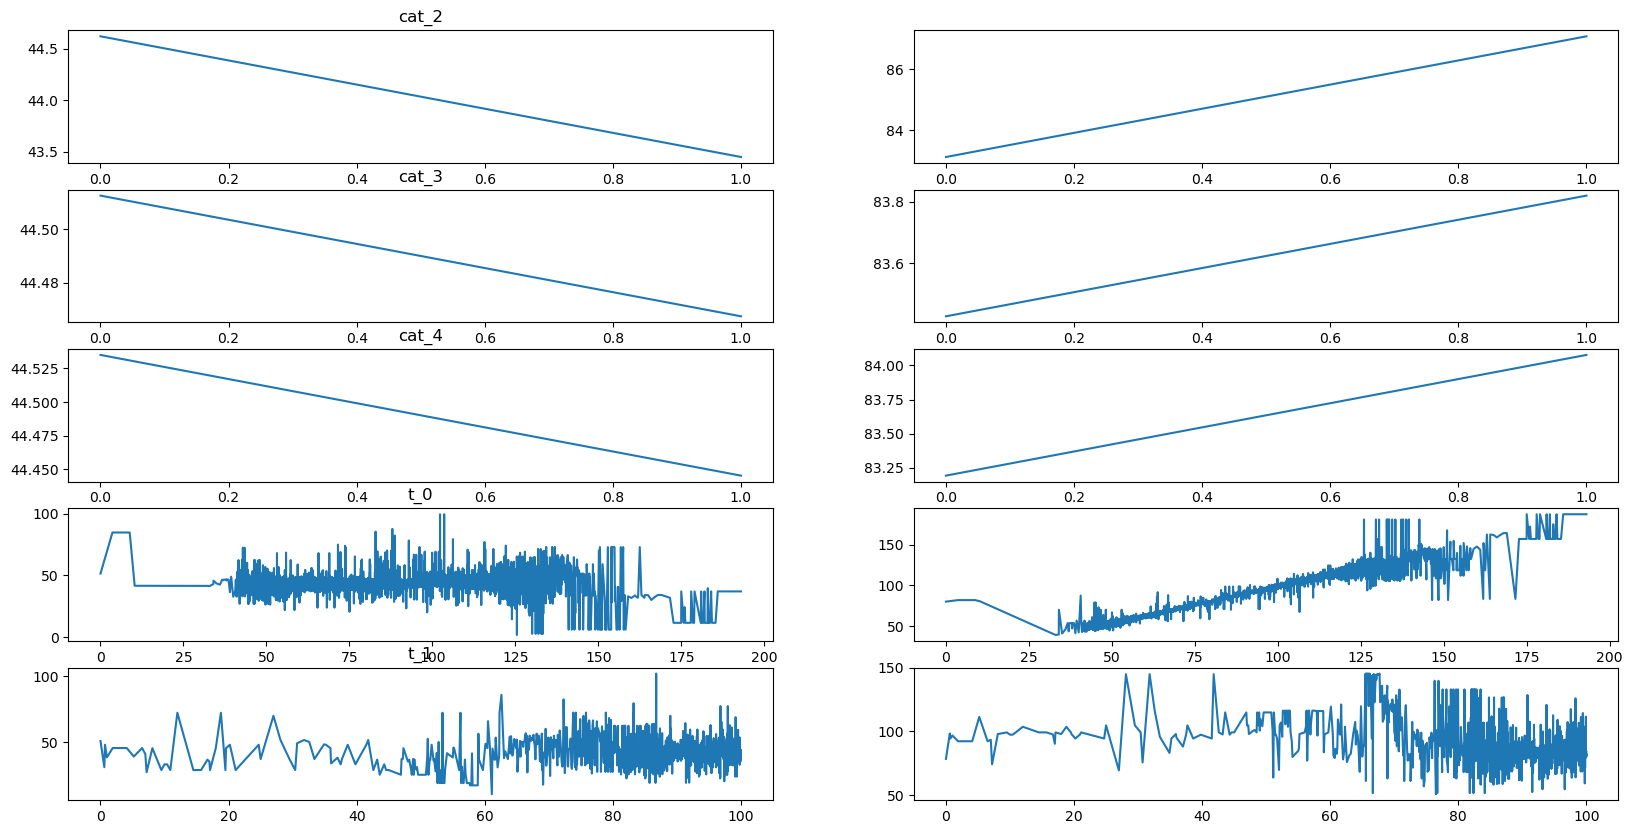

In [18]:
fig, ax=plt.subplots(nrows=5,ncols=2,figsize=(20,10))
for i,col in enumerate(df.columns[8:13]):
    ax[i,0].set_title(col)
    ax[i,0].plot(df.groupby(col).mean()['y_1'])
    ax[i,1].plot(df.groupby(col).mean()['y_2'])
plt.show()

/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/1864802247.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[i,0].plot(df.groupby(col).mean()['y_1'])
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/1864802247.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[i,1].plot(df.groupby(col).mean()['y_2'])
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/1864802247.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only

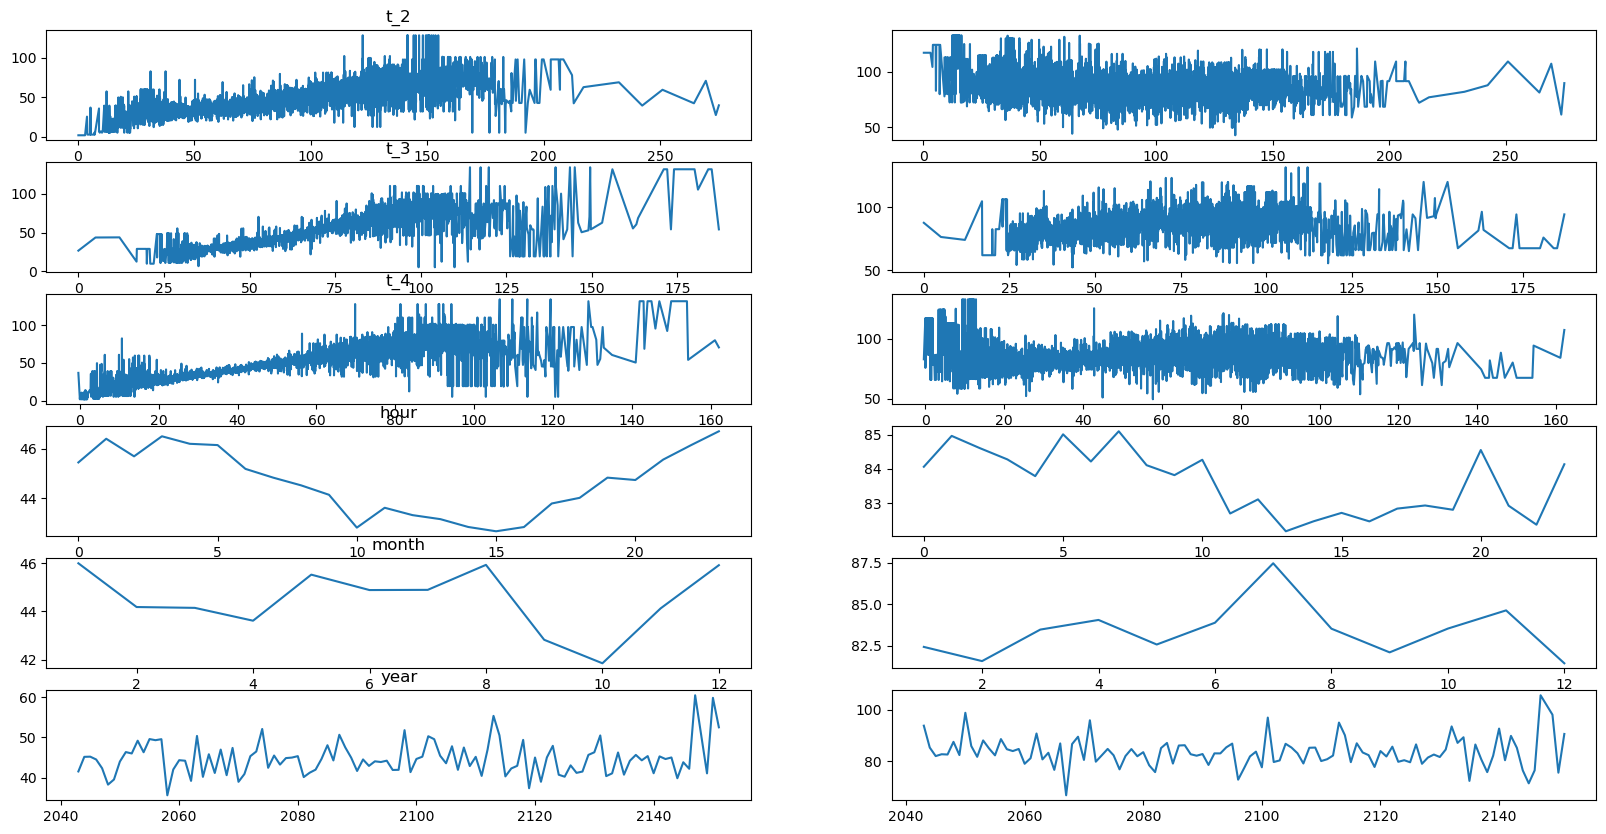

In [19]:
fig, ax=plt.subplots(nrows=6,ncols=2,figsize=(20,10))
for i,col in enumerate(list(df.columns[13:16])+list(df.columns[18:21])):
    ax[i,0].set_title(col)
    ax[i,0].plot(df.groupby(col).mean()['y_1'])
    ax[i,1].plot(df.groupby(col).mean()['y_2'])
plt.show()

In [20]:
df.describe()

,obs,sub_id,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4,y_1,y_2,hour,month,year
count,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000,432600.00000,432600.000000,432600.000000,432600.000000,432600.000000,432600.000000
mean,8897.637517,926.451734,-0.029135,32.900763,4.546047,0.431969,3.188141,0.100069,0.218932,0.361442,83.413876,93.972874,79.452092,59.789933,43.38801,44.502572,83.512735,11.964397,6.290908,2093.941616
std,5143.270789,606.562762,0.970960,13.716405,3.613130,0.495351,1.601721,0.300093,0.413523,0.480419,16.362968,16.512583,20.984657,12.773001,14.42101,14.305453,16.230752,6.529854,3.206981,30.074135
min,0.000000,0.000000,-2.940000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,-0.40000,0.460000,0.000000,0.000000,1.000000,2043.000000
25%,4429.750000,365.000000,-0.620000,24.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,72.000000,95.000000,64.220000,51.000000,33.00000,34.340000,72.220000,7.000000,4.000000,2065.000000
50%,8926.500000,879.000000,0.060000,31.000000,4.000000,0.000000,3.000000,0.000000,0.000000,0.000000,82.200000,97.000000,77.100000,58.550000,41.50000,42.740000,82.535000,12.000000,6.000000,2094.000000
75%,13444.250000,1473.000000,0.750000,42.000000,7.000000,1.000000,5.000000,0.000000,0.000000,1.000000,93.900000,99.000000,92.930000,66.810000,52.00000,52.840000,93.752500,18.000000,9.000000,2120.000000
max,17869.000000,1995.000000,1.500000,90.000000,19.000000,1.000000,6.000000,1.000000,1.000000,1.000000,193.000000,100.000000,275.200000,187.100000,162.10000,134.520000,190.030000,23.000000,12.000000,2151.000000


check how many sub_id's per obs

In [21]:
# df.groupby('obs').nunique()['sub_id'].sort_values()
df.groupby('obs').nunique()['cat_4'].sort_values()

obs
0        1
11859    1
11860    1
11861    1
11862    1
        ..
5801     1
5802     1
5803     1
5835     1
17869    1
Name: cat_4, Length: 14420, dtype: int64

In [22]:
df['cat_1'].unique()

array([3, 2, 1, 5, 6])

In [23]:
df.columns

Index(['obs', 'sub_id', 'time', 'num_0', 'num_1', 'num_2', 'cat_0', 'cat_1',
       'cat_2', 'cat_3', 'cat_4', 't_0', 't_1', 't_2', 't_3', 't_4', 'y_1',
       'y_2', 'hour', 'month', 'year'],
      dtype='object')

In [24]:
df.sort_values(['obs','time'])
mean_df=df.groupby('obs').first()[['num_0','num_1','num_2','cat_0','cat_1','cat_2','cat_3','cat_4','t_0','t_1','t_2','t_3','t_4','year','month','hour','y_1','y_2']]

In [25]:
mean_df_last=df.groupby('obs').last()[['t_0','t_1','t_2','t_3','t_4']]
mean_df_mean=df.groupby('obs').mean()[['t_0','t_1','t_2','t_3','t_4']]
mean_df_var=df.groupby('obs').var()[['t_0','t_1','t_2','t_3','t_4']]

/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/4272269679.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df_mean=df.groupby('obs').mean()[['t_0','t_1','t_2','t_3','t_4']]
/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/4272269679.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df_var=df.groupby('obs').var()[['t_0','t_1','t_2','t_3','t_4']]


Creating new features based on the different groupby functions

In [26]:
mean_df[['t_0d','t_1d','t_2d','t_3d','t_4d']]=mean_df_last
mean_df[['t_0m','t_1m','t_2m','t_3m','t_4m']]=mean_df_mean
mean_df[['t_0v','t_1v','t_2v','t_3v','t_4v']]=mean_df_var

In [27]:
x_train, x_test, y_train, y_test = train_test_split(mean_df[['num_0','num_1','num_2','cat_0','cat_1','cat_2','cat_3','cat_4','t_0','t_1','t_2','t_3','t_4','year','month','hour','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']], mean_df[['y_1','y_2']], test_size=0.2, random_state=13)

In [28]:
kf = KFold(n_splits=10, random_state=13, shuffle = True)
kf.get_n_splits(x_train)

10

In [29]:
#lasso cross validation
alpha_vals=[1e-3, 1e-2, 1e-1,0.08, 1, 10]
r2_scores=[[] for i in range(len(alpha_vals))]
for k,j in kf.split(x_train):
    cv_x_train,cv_x_test=x_train.iloc[k,:].copy(),x_train.iloc[j,:].copy()
    scaler = StandardScaler()
    cv_x_train = scaler.fit_transform(cv_x_train)
    cv_x_test = scaler.transform(cv_x_test)
    cv_y_train,cv_y_test=y_train.iloc[k,:],y_train.iloc[j,:]
    # cv_y_train2,cv_y_test2=y_train.iloc[k,1],y_train.iloc[j,1]
    for i,alpha in enumerate(alpha_vals):
        mod=Lasso(alpha=alpha).fit(cv_x_train, cv_y_train)
        cv_y_test_est=mod.predict(cv_x_test)
        r2 = mean_absolute_error(cv_y_test, cv_y_test_est)
        # r2=0
        r2_scores[i].append(r2)


/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66011.20456978097, tolerance: 213.47943049141202
  model = cd_fast.enet_coordinate_descent(
/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64424.417844874144, tolerance: 210.32078545055
  model = cd_fast.enet_coordinate_descent(
/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57429.635984627006, tolerance: 212.0426766193065
  model = cd_fast.enet_coordinate_descent(
/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packag

In [30]:
alpha_r2_avg_lasso=dict(zip(alpha_vals,[np.mean(score) for score in r2_scores]))
alpha_r2_avg_lasso

{0.001: 4.304788260030617,
 0.01: 4.304885498493224,
 0.1: 4.3147563484532,
 0.08: 4.312569027099328,
 1: 4.521841364506658,
 10: 9.534716013276642}

In [31]:
#ridge cross validation
alpha_vals=[0,1e-3, 1e-2, 1e-1, 1, 10]
r2_scores=[[] for i in range(len(alpha_vals))]
for k,j in kf.split(x_train):
    cv_x_train,cv_x_test=x_train.iloc[k,:].copy(),x_train.iloc[j,:].copy()
    scaler = StandardScaler()
    cv_x_train = scaler.fit_transform(cv_x_train)
    cv_x_test = scaler.transform(cv_x_test)
    cv_y_train,cv_y_test=y_train.iloc[k,:],y_train.iloc[j,:]
    # rf_best = RandomForestRegressor(max_depth=9, max_features=0.7,
    #                   min_samples_leaf=7,n_estimators=100)
    # rf_best.fit(cv_x_train,cv_y_train)
    # y_pred_test=rf_best.predict(cv_x_test)
    for i,alpha in enumerate(alpha_vals):
        mod=Ridge(alpha=alpha).fit(cv_x_train, cv_y_train)
        cv_y_test_est=mod.predict(cv_x_test)
        r2 = mean_absolute_error(cv_y_test, cv_y_test_est)
        r2_scores[i].append(r2)


In [32]:
alpha_r2_avg_ridge=dict(zip(alpha_vals,[np.mean(score) for score in r2_scores]))
alpha_r2_avg_ridge

{0: 4.305674095798201,
 0.001: 4.305673946362703,
 0.01: 4.305672602872073,
 0.1: 4.305659323476986,
 1: 4.305571354316458,
 10: 4.305633011764996}

In [33]:
#lasso+rf cross validation
alpha_vals=[1e-3, 1e-2, 1e-1, 1, 10]
r2_scores=[[] for i in range(len(alpha_vals))]
for k,j in kf.split(x_train):
    cv_x_train,cv_x_test=x_train.iloc[k,:],x_train.iloc[j,:]
    scaler = StandardScaler()
    cv_x_train = scaler.fit_transform(cv_x_train)
    cv_x_test = scaler.transform(cv_x_test)
    cv_y_train,cv_y_test=y_train.iloc[k,:],y_train.iloc[j,:]
    rf_best = RandomForestRegressor(max_depth=9, max_features=0.7,
                      min_samples_leaf=7,n_estimators=100)
    rf_best.fit(cv_x_train,cv_y_train)
    y_pred_test=rf_best.predict(cv_x_test)
    for i,alpha in enumerate(alpha_vals):
        mod=Lasso(alpha=alpha).fit(cv_x_train, cv_y_train)
        cv_y_test_est=mod.predict(cv_x_test)
        r2 = mean_absolute_error(cv_y_test, (cv_y_test_est+y_pred_test)/2)
        r2_scores[i].append(r2)


/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66011.20456978097, tolerance: 213.47943049141202
  model = cd_fast.enet_coordinate_descent(
/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64424.417844874144, tolerance: 210.32078545055
  model = cd_fast.enet_coordinate_descent(
/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57429.635984627006, tolerance: 212.0426766193065
  model = cd_fast.enet_coordinate_descent(
/Users/kevin_yang/opt/anaconda3/lib/python3.8/site-packag

In [34]:
alpha_r2_avg_lasso2=dict(zip(alpha_vals,[np.mean(score) for score in r2_scores]))
alpha_r2_avg_lasso2

{0.001: 4.278826923311336,
 0.01: 4.282074176234774,
 0.1: 4.292820225497003,
 1: 4.378288282681489,
 10: 6.337156667986902}

In [35]:
#lasso+rf cross validation
alpha_vals=[0,1e-3, 1e-2, 1e-1, 1, 10]
r2_scores=[[] for i in range(len(alpha_vals))]
for k,j in kf.split(x_train):
    cv_x_train,cv_x_test=x_train.iloc[k,:],x_train.iloc[j,:]
    scaler = StandardScaler()
    cv_x_train = scaler.fit_transform(cv_x_train)
    cv_x_test = scaler.transform(cv_x_test)
    cv_y_train,cv_y_test=y_train.iloc[k,:],y_train.iloc[j,:]
    rf_best = RandomForestRegressor(max_depth=9, max_features=0.7,
                      min_samples_leaf=7,n_estimators=100)
    rf_best.fit(cv_x_train,cv_y_train)
    y_pred_test=rf_best.predict(cv_x_test)
    for i,alpha in enumerate(alpha_vals):
        mod=Ridge(alpha=alpha).fit(cv_x_train, cv_y_train)
        cv_y_test_est=mod.predict(cv_x_test)
        r2 = mean_absolute_error(cv_y_test, (cv_y_test_est+y_pred_test)/2)
        r2_scores[i].append(r2)

In [36]:
alpha_r2_avg_ridge2=dict(zip(alpha_vals,[np.mean(score) for score in r2_scores]))
alpha_r2_avg_ridge2

{0: 4.277184334522479,
 0.001: 4.277184398298955,
 0.01: 4.277184972434576,
 0.1: 4.277190728225593,
 1: 4.277250027635717,
 10: 4.278027872043479}

In [37]:
{'lasso':alpha_r2_avg_lasso,'ridge':alpha_r2_avg_ridge,'lasso+rf':alpha_r2_avg_lasso2,'ridge+rf':alpha_r2_avg_ridge2}

{'lasso': {0.001: 4.304788260030617,
  0.01: 4.304885498493224,
  0.1: 4.3147563484532,
  0.08: 4.312569027099328,
  1: 4.521841364506658,
  10: 9.534716013276642},
 'ridge': {0: 4.305674095798201,
  0.001: 4.305673946362703,
  0.01: 4.305672602872073,
  0.1: 4.305659323476986,
  1: 4.305571354316458,
  10: 4.305633011764996},
 'lasso+rf': {0.001: 4.278826923311336,
  0.01: 4.282074176234774,
  0.1: 4.292820225497003,
  1: 4.378288282681489,
  10: 6.337156667986902},
 'ridge+rf': {0: 4.277184334522479,
  0.001: 4.277184398298955,
  0.01: 4.277184972434576,
  0.1: 4.277190728225593,
  1: 4.277250027635717,
  10: 4.278027872043479}}

The best model seems to be an ensemble model of Ridge Regression and Random Forest

In [38]:
alpha=0
rf_best = RandomForestRegressor(max_depth=9, max_features=0.7,
                      min_samples_leaf=7,n_estimators=100)
rf_best.fit(x_train[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']],y_train)
y_pred_test_rf=rf_best.predict(x_test[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']])
mod=Ridge(alpha=alpha).fit(x_train[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']],y_train)
y_pred_test_ri=mod.predict(x_test[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']])
#test error
mean_absolute_error(y_test, (y_pred_test_rf+y_pred_test_ri)/2)

4.324034882803362

### Using the Test Dataset to produce first batch of inferences

In [39]:
final_mod_lr=Ridge(alpha=alpha).fit(mean_df[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']], mean_df[['y_1','y_2']])
final_mod_rf=RandomForestRegressor(max_depth=9, max_features=0.7,
                      min_samples_leaf=7,n_estimators=100)
final_mod_rf.fit(mean_df[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']], mean_df[['y_1','y_2']])

RandomForestRegressor(max_depth=9, max_features=0.7, min_samples_leaf=7)

In [40]:
df_test = pd.read_csv("data/test_no_outcome.csv")
df_test.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4
0,18,1,2134-04-01 22:23:14,-1.0,38,1,1,1,0,0,0,105.4,99.8,50.7,61.4,36.8
1,18,1,2134-04-01 22:24:14,-1.0,38,1,1,1,0,0,0,105.4,99.4,49.4,61.1,36.2
2,18,1,2134-04-01 22:25:14,-1.0,38,1,1,1,0,0,0,104.6,99.0,49.7,61.4,36.6
3,18,1,2134-04-01 22:26:14,-1.0,38,1,1,1,0,0,0,104.5,99.6,51.7,61.8,37.2
4,18,1,2134-04-01 22:27:14,-1.0,38,1,1,1,0,0,0,104.6,99.5,52.5,61.9,37.5


In [41]:
df_test['time']=pd.to_datetime(df_test['time']) 
df_test['hour']=df_test['time'].dt.hour
df_test['month']=df_test['time'].dt.month
df_test['year']=df_test['time'].dt.year

In [42]:
df_test.sort_values(['obs','time'],inplace=True)

In [43]:
mean_df_test=df_test.groupby('obs').first()[['num_0','num_1','num_2','cat_0','cat_1','cat_2','cat_3','cat_4','t_0','t_1','t_2','t_3','t_4','year','month','hour']]
mean_df_test_last=df_test.groupby('obs').last()[['t_0','t_1','t_2','t_3','t_4']]
mean_df_test_mean=df_test.groupby('obs').mean()[['t_0','t_1','t_2','t_3','t_4']]
mean_df_test[['t_0d','t_1d','t_2d','t_3d','t_4d']]=mean_df_test_last
mean_df_test[['t_0m','t_1m','t_2m','t_3m','t_4m']]=mean_df_test_mean


/var/folders/rp/w4jh5qxd1gd5qhqv_rsk4syw0000gn/T/ipykernel_25944/2284063198.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df_test_mean=df_test.groupby('obs').mean()[['t_0','t_1','t_2','t_3','t_4']]


In [44]:
mean_df_test_pred_lr=final_mod_lr.predict(mean_df_test[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']])
mean_df_test_pred_rf=final_mod_rf.predict(mean_df_test[['t_0','t_1','t_2','t_3','t_4','t_0d','t_1d','t_2d','t_3d','t_4d','t_0m','t_1m','t_2m','t_3m','t_4m']]) 

In [45]:
mean_df_test_pred_lr

array([[ 40.97691083, 105.11142517],
       [ 32.72499798, 100.74825549],
       [ 35.30873205,  95.79728596],
       ...,
       [ 48.87674358, 111.92530803],
       [ 46.45277061, 100.70682248],
       [ 53.3018092 , 105.17312906]])

In [46]:
mean_df_test_pred=(mean_df_test_pred_lr+mean_df_test_pred_rf)/2

In [47]:
pd.DataFrame(mean_df_test_pred,index=mean_df_test.index,columns=['y_1','y_2']).to_csv('submission1.csv')